In [7]:
import segmentation_models_pytorch as smp
import torch

checkpoint_full = torch.load(
    "/home/emilia/WaterSegNet/checkpoints/checkpoints_full/model-unet_resnet34_adam_padded_b16.ckpt"
)
checkpoint_uav = torch.load(
    "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-unet_resnet34_adam_padded_b16_e20.ckpt"
)


state_dict_full = checkpoint_full["state_dict"]
state_dict_uav = checkpoint_uav["state_dict"]


model_full = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None,
)
model_uav = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_full.to(device)
model_full.load_state_dict(state_dict_full)

model_uav.to(device)
model_uav.load_state_dict(state_dict_uav)

<All keys matched successfully>

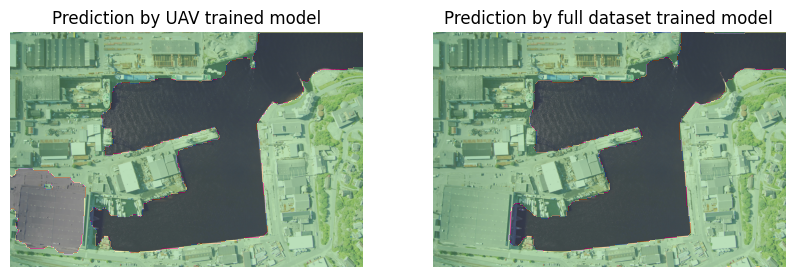

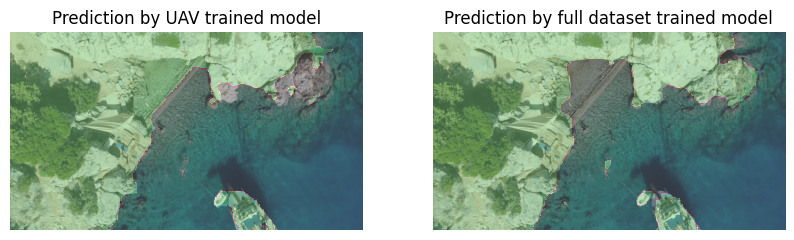

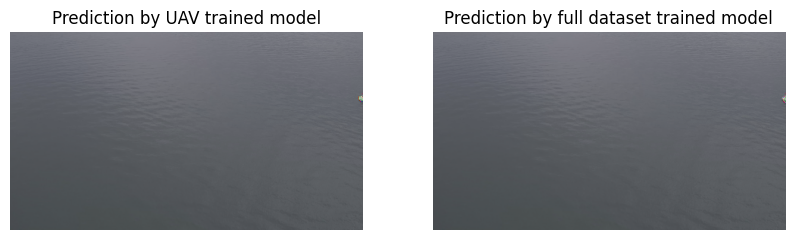

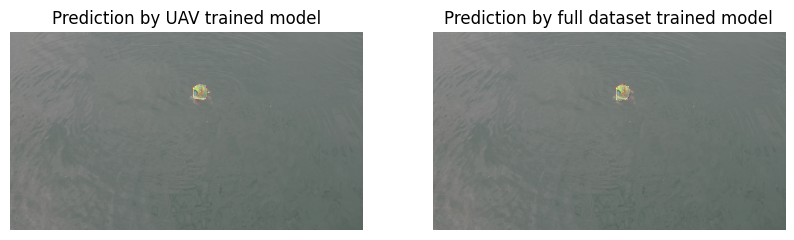

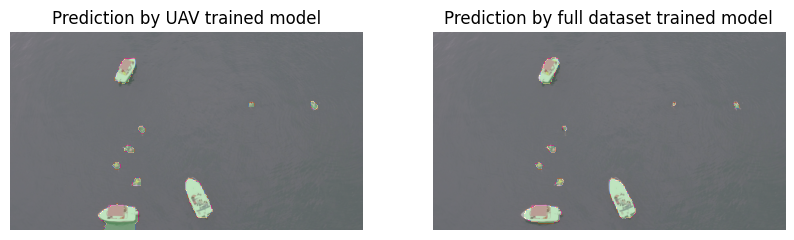

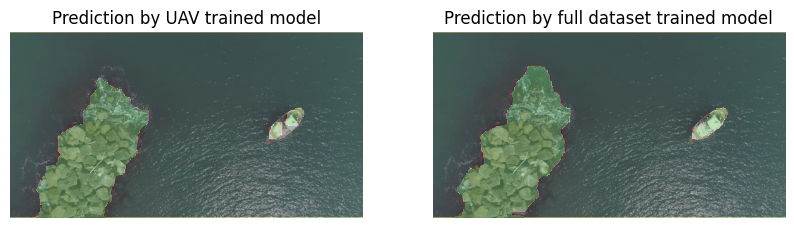

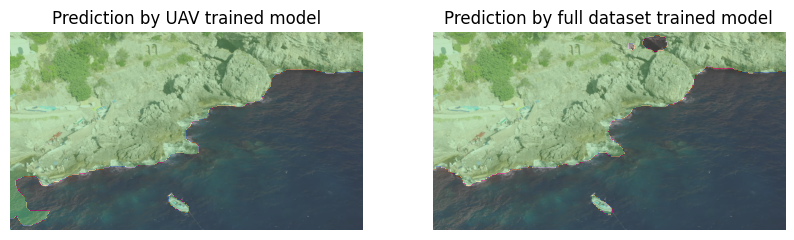

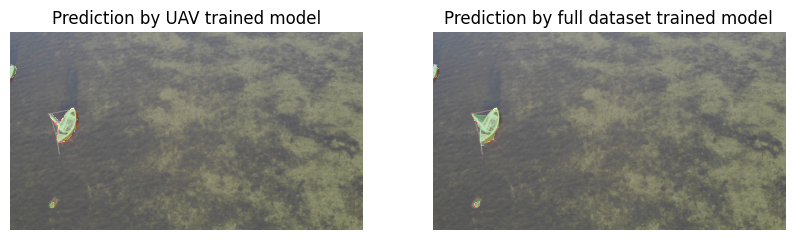

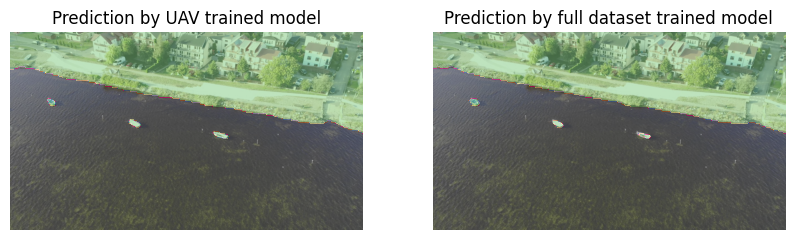

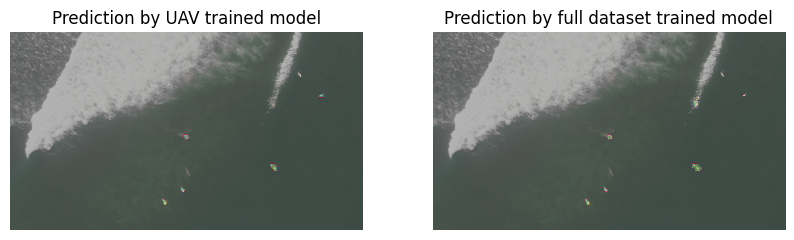

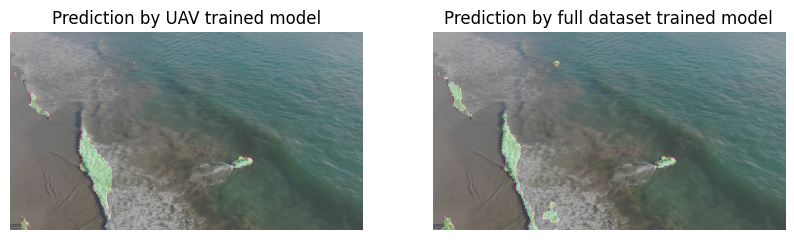

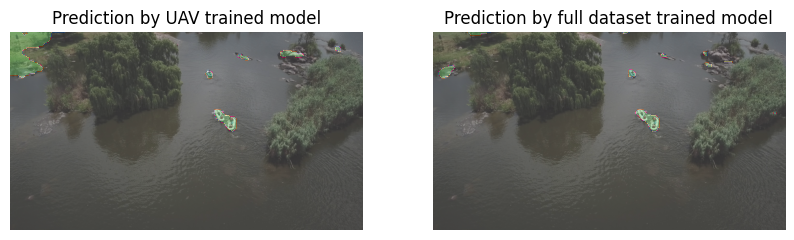

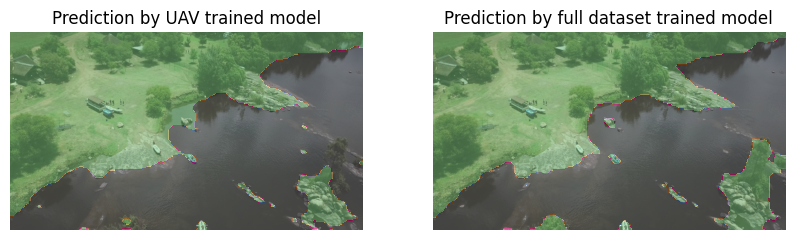

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from lib.dataloader import SegDataset


def remove_border(mask, original_size):
    h, w = mask.shape
    orig_h, orig_w = original_size
    delta_w = w - orig_w
    delta_h = h - orig_h

    if delta_w > 0:
        mask = mask[:, delta_w // 2 : -delta_w // 2]
    if delta_h > 0:
        mask = mask[delta_h // 2 : -delta_h // 2, :]
    return mask


def predict_image(model, image, device):
    model.eval()
    img = torch.from_numpy(SegDataset.preprocess(image, is_mask=False))
    img = img.unsqueeze(0).to(device, dtype=torch.float32)
    with torch.no_grad():
        pred = model(img).cpu()
        max_dim = max(image.size)
        pred = F.interpolate(pred, size=(max_dim, max_dim))
        mask = torch.sigmoid(pred) > 0.5

    mask_np = mask[0].long().squeeze().numpy()
    mask_np = remove_border(mask_np, original_size=(image.size[1], image.size[0]))
    return mask_np


def plot_predictions(image_raw, model_1, model_2, device):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_raw)
    mask = predict_image(model_1, image_raw, device)
    plt.imshow(mask, alpha=0.5, cmap="Accent")
    plt.title("Prediction by UAV trained model")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(image_raw)
    mask = predict_image(model_2, image_raw, device)
    plt.imshow(mask, alpha=0.5, cmap="Accent")
    plt.title("Prediction by full dataset trained model")
    plt.axis("off")


image = Image.open("/home/emilia/WaterSegNet/test/trondheim.jpg")
plot_predictions(image, model_uav, model_full, device)

for i in range(1, 13):
    image_raw = Image.open("/home/emilia/WaterSegNet/test/" + str(i) + ".jpg")
    plot_predictions(image_raw, model_uav, model_full, device)